### Import libraries

In [12]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn import preprocessing
from scipy import stats
import csv

I tried to get read of a warning error 

In [13]:
import os
import sys
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Keras outputs warnings using `print` to stderr so let's direct that to devnull temporarily
stderr = sys.stderr
sys.stderr = open(os.devnull, 'w')

import keras

# we're done
sys.stderr = stderr

from keras.backend.tensorflow_backend import tf

import absl.logging
logging.root.removeHandler(absl.logging._absl_handler)
absl.logging._warn_preinit_stderr = False

logger = tf.get_logger()
logger.setLevel(logging.FATAL)

graph = tf.get_default_graph()

In [14]:
# load the new file (lastest dataset with color_normalize loading rates)
dataset = read_csv('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Data/Raw/ExperimentalLakes/ExperimentalLakes_Data_withColorNormalizedCumulativePloading.csv', header=0, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])

In [15]:
#Data Preprocessing (Filtering the Peter Lake data, keep only Chla column, droping missing Chl values, normalizing Chla data)

def data_prep_uni(dataset, lake):
    ex = dataset[dataset.lake==lake]
    ex = ex.dropna(subset=["chl"])
    ex = ex.chl.values
    #min_max_scaler = preprocessing.MinMaxScaler()
    #ex = min_max_scaler.fit_transform(ex.reshape(-1, 1))*100
    return ex

In [22]:
ex_R = data_prep_uni (dataset,"R")
ex_T = data_prep_uni (dataset,"T")

In [23]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:816], data[816:]
	# restructure into windows of weekly data
	#train = array(split(train, len(train)/7))
	#test = array(split(test, len(test)/7))
	return train, test

In [24]:
# split into train and test
train, test = split_dataset(ex_R)
train= train.reshape(train.shape[0], 1)
test= test.reshape(test.shape[0], 1)

In [31]:
# split a univariate dataset into train/test sets
def split_dataset_T(data):
	# split into standard weeks
	train, test = data[1:194], data[194:]
	# restructure into windows of weekly data
	#train = array(split(train, len(train)/7))
	#test = array(split(test, len(test)/7))
	return train, test

In [32]:
# split into train and test
train_T, test_T = split_dataset_T(ex_T)
train_T= train_T.reshape(train_T.shape[0], 1)
test_T= test_T.reshape(test_T.shape[0], 1)

In [34]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], 1))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [35]:
np.savetxt('test_observations.csv', test, fmt='%1.6f', delimiter=',')

# Naive Model

In [36]:
# naive forecast strategies for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [37]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts_Naive(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
        # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [38]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [39]:
#evaluate a single model
def evaluate_model_naive(daily_persistence, train, test):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)-7):
        # predict the week
        yhat_sequence = daily_persistence(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = array(predictions)
    test_x, test_y= to_supervised(test, 7, 1)
    
    score, scores= evaluate_forecasts_Naive(test_x, predictions)
    # evaluate predictions days for each week
    return score, scores, predictions

In [40]:
# daily persistence model
def daily_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    # get the total active power for the last day
    value = last_week[-1]
    # prepare 7 day forecast
    forecast = [value for _ in range(7)]
    return forecast

In [41]:
# evaluate and get scores
score_Naive, scores_Naive, prediction_Naive = evaluate_model_naive (daily_persistence, train, test)

In [42]:
# summarize scores
summarize_scores('Daily Persistence', score_Naive, scores_Naive)

Daily Persistence: [7.314] 2.8, 4.5, 6.1, 7.4, 8.4, 9.2, 9.9


In [43]:
np.savetxt('prediction_Naive.csv', prediction_Naive, fmt='%1.6f', delimiter=',')

r_value_Naive= []
for i in range(7):
    r_value= stats.linregress(test_x[7:, i, 0], prediction_Naive[:, i])[2]
    r_value_Naive.append(r_value)


In [44]:
# evaluate and get scores
score_Naive_T, scores_Naive_T, prediction_Naive_T = evaluate_model_naive (daily_persistence, train_T, test_T)

In [45]:
# summarize scores
summarize_scores('Daily Persistence', score_Naive_T, scores_Naive_T)

Daily Persistence: [7.037] 4.4, 5.1, 5.7, 7.0, 8.0, 8.2, 9.4


slope, intercept, r_value, p_value, std_err = stats.linregress(test_x[7:, 6, 0], prediction_Naive[:, 6])
print(slope, intercept, r_value, p_value, std_err)

# Univariate models

## CNN multi-step forecasting

In [64]:
# train the model
def build_model_CNN(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 50, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(Conv1D(32, 2, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(MaxPooling1D())
	model.add(Flatten())
	model.add(Dense(50, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [65]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	#data = data.reshape((data.shape[0]*data.shape[1], 1))
	# retrieve last observations for input data (It is 7 last observations of train data)
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [66]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[7:, i], predicted[7:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [67]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [68]:
# evaluate a single model
def evaluate_model_CNN(train, test, n_input):
	# fit model
	model = build_model_CNN(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)-7):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	test_x, test_y= to_supervised(test, 7, 1)
	score, scores = evaluate_forecasts(test_x[:, :, 0], predictions)
	return score, scores, predictions

In [69]:
# evaluate model and get scores
n_input = 7
score_CNN, scores_CNN, prediction_CNN= evaluate_model_CNN(train, test, n_input)

In [70]:
# summarize scores
summarize_scores('cnn', score_CNN, scores_CNN)

cnn: [6.984] 3.4, 4.8, 6.1, 7.3, 8.2, 8.9, 9.6


slope, intercept, r_value, p_value, std_err = stats.linregress(test_x[7:, 6, 0], prediction_CNN[:, 6])
print(slope, intercept, r_value, p_value, std_err)

In [71]:
prediction_CNN.shape

(109, 7)

In [72]:
np.savetxt('prediction_CNN.csv', prediction_CNN, fmt='%1.6f', delimiter=',')

In [73]:
doy = range(139,248)
actual = test[6:-1]

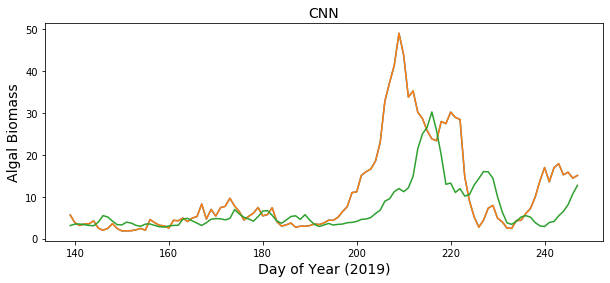

In [74]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
CNN = prediction_CNN [:,6]
plt.plot(doy,actual, doy, CNN)
plt.title("CNN", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

### CNN multi-step forecasting (T)

In [75]:
# evaluate model and get scores
n_input = 7
score_CNN_T, scores_CNN_T, prediction_CNN_T= evaluate_model_CNN(train, test_T, n_input)

In [76]:
# summarize scores
summarize_scores('cnn_T', score_CNN_T, scores_CNN_T)

cnn_T: [8.980] 4.4, 6.0, 7.1, 8.7, 9.9, 11.5, 13.0


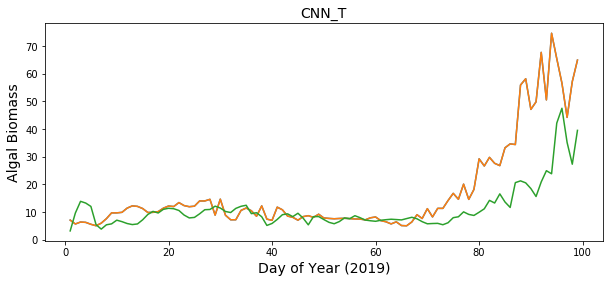

In [77]:
doy_T = range(1,100)
actual_T = test_T[6:-1]
plt.figure(figsize=(10,4))
plt.plot(doy_T,actual_T, label='Actual')
CNN_T = prediction_CNN_T [:,6]
plt.plot(doy_T,actual_T, doy_T, CNN_T)
plt.title("CNN_T", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

# LSTM Univariate

In [78]:
from keras.layers import LSTM

In [79]:
# train the model
def build_model_LSTM(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [80]:
# evaluate a single model
def evaluate_model_LSTM(train, test, n_input):
    # fit model
    model = build_model_LSTM(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)-7):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    test_x, test_y= to_supervised(test, 7, 1)
    score, scores = evaluate_forecasts_Naive(test_x[:, :], predictions)
    return score, scores, predictions

In [81]:
# evaluate model and get scores
n_input = 7
score_LSTM, scores_LSTM, predictions_LSTM = evaluate_model_LSTM(train, test, n_input)
# summarize scores
summarize_scores('lstm', score_LSTM, scores_LSTM)

lstm: [6.863] 4.3, 5.5, 6.4, 7.1, 7.7, 7.9, 8.2


In [82]:
np.savetxt('predictions_LSTM.csv', predictions_LSTM,fmt='%1.6f', delimiter=',')

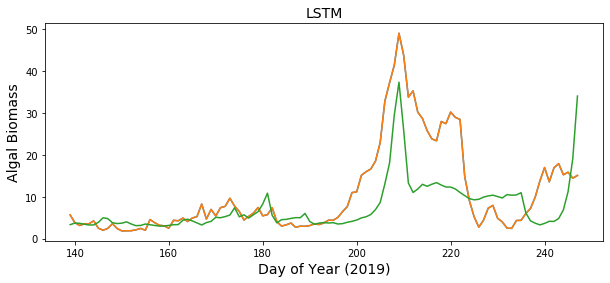

In [83]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
LSTM = predictions_LSTM [:,6]
plt.plot(doy,actual, doy, LSTM)
plt.title("LSTM", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

### LSTM forecasting (T)

In [84]:
from keras.layers import LSTM

In [85]:
# evaluate model and get scores
n_input = 7
score_LSTM_T, scores_LSTM_T, prediction_LSTM_T= evaluate_model_LSTM(train, test_T, n_input)

In [86]:
# summarize scores
summarize_scores('LSTM_T', score_LSTM_T, scores_CNN_T)

LSTM_T: [13.547] 4.4, 6.0, 7.1, 8.7, 9.9, 11.5, 13.0


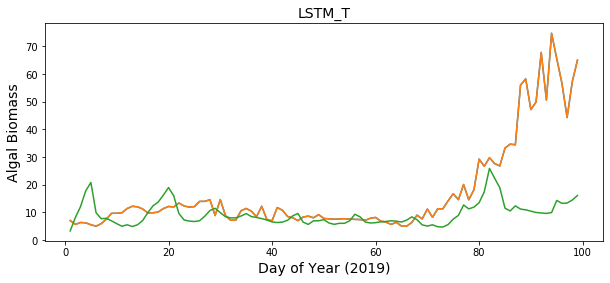

In [87]:
doy_T = range(1,100)
actual_T = test_T[6:-1]
plt.figure(figsize=(10,4))
plt.plot(doy_T,actual_T, label='Actual')
LSTM_T = prediction_LSTM_T [:,6]
plt.plot(doy_T,actual_T, doy_T, LSTM_T)
plt.title("LSTM_T", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

## Encoder- Decoder LSTM with univariate input

In [88]:
from keras.layers import LSTM

In [89]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [90]:
# train the model
def build_model_LSTM_EnDe(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [91]:
# evaluate a single model
def evaluate_model_LSTM_EnDe(train, test, n_input):
    # fit model
    model = build_model_LSTM_EnDe(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)-7):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    test_x, test_y= to_supervised(test, 7, 1)
    score, scores = evaluate_forecasts_Naive(test_x[:, :], predictions)
    return score, scores, predictions

In [92]:
# evaluate model and get scores
n_input = 7
score_LSTM_EnDe, scores_LSTM_EnDe, predictions_LSTM_EnDe = evaluate_model_LSTM_EnDe(train, test, n_input)
# summarize scores
summarize_scores('lstm_EnDe', score_LSTM_EnDe, scores_LSTM_EnDe)

lstm_EnDe: [6.289] 3.5, 4.8, 6.0, 6.7, 7.0, 7.3, 7.6


In [93]:
predictions_LSTM_EnDe= predictions_LSTM_EnDe.reshape(predictions_LSTM_EnDe.shape[0], predictions_LSTM_EnDe.shape[1])

In [94]:
np.savetxt('predictions_LSTM_EnDe.csv', predictions_LSTM_EnDe, fmt='%1.6f', delimiter=',')

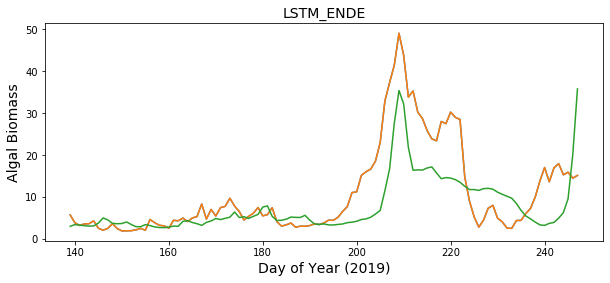

In [95]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
LSTM_ENDE = predictions_LSTM_EnDe [:,6]
plt.plot(doy,actual, doy, LSTM_ENDE)
plt.title("LSTM_ENDE", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

## Encoder- Decoder LSTM with univariate input(T)

In [96]:
# evaluate model and get scores
n_input = 7
score_LSTM_EnDe_T, scores_LSTM_EnDe_T, predictions_LSTM_EnDe_T = evaluate_model_LSTM_EnDe(train, test_T, n_input)
# summarize scores
summarize_scores('lstm_EnDe_T', score_LSTM_EnDe_T, scores_LSTM_EnDe_T)

lstm_EnDe_T: [13.767] 8.9, 11.1, 12.6, 13.9, 14.8, 16.1, 17.2


In [97]:
predictions_LSTM_EnDe_T= predictions_LSTM_EnDe_T.reshape(predictions_LSTM_EnDe_T.shape[0], predictions_LSTM_EnDe_T.shape[1])

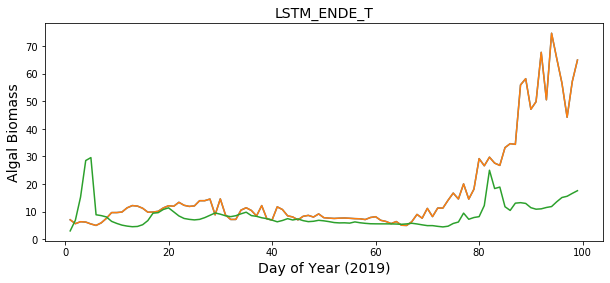

In [98]:
plt.figure(figsize=(10,4))
plt.plot(doy_T,actual_T, label='Actual')
LSTM_ENDE_T = predictions_LSTM_EnDe_T [:,6]
plt.plot(doy_T,actual_T, doy_T, LSTM_ENDE_T)
plt.title("LSTM_ENDE_T", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

# MLP Multi-step

In [99]:
# convert history into inputs and outputs
def to_supervised_MLP(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end]
			X.append(x_input)
			y.append(data[in_end:out_end])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [100]:
# train the model
def build_model_MLP(train, config):
    # prepare data
    n_input, n_nodes, n_epochs, n_batch = config
    train_x, train_y = to_supervised_MLP(train, n_input)
    # define parameters
    n_timesteps, n_outputs = train_x.shape[1], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

In [101]:
# make a forecast
def forecast_MLP(model, history, n_input):
	# flatten data
	data = array(history)
	#data = data.reshape((data.shape[0]*data.shape[1]))
	# retrieve last observations for input data
	input_x = data[-n_input:]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x)))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [102]:
# evaluate a single model
def evaluate_model_MLP(train, test, n_input):
    # fit model
    model = build_model_MLP(train, config)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)-7):
        # predict the week
        yhat_sequence = forecast_MLP(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    test_x, test_y= to_supervised(test, 7, 1)
    score, scores = evaluate_forecasts(test_x[:,:], predictions)
    return score, scores, predictions

In [103]:
# evaluate model and get scores
config = [7, 50, 50, 4]
score_MLP, scores_MLP, predictions_MLP = evaluate_model_MLP(train, test, n_input)
# summarize scores
summarize_scores('MLP', score_MLP, scores_MLP)

MLP: [7.056] 3.1, 4.6, 6.1, 7.3, 8.5, 9.2, 9.7


In [104]:
np.savetxt('predictions_MLP.csv', predictions_MLP, fmt='%1.6f', delimiter=',')

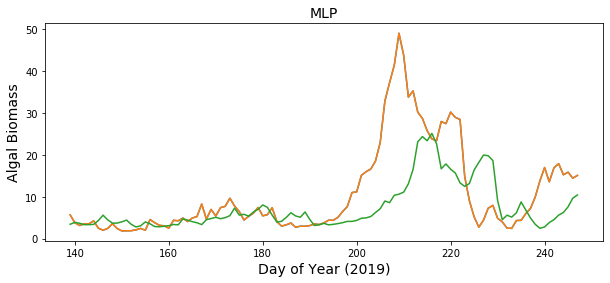

In [105]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
MLP = predictions_MLP [:,6]
plt.plot(doy,actual, doy, MLP)
plt.title("MLP", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

## CNN-LSTM Encoder-Decoder With Univariate Input

In [106]:
# train the model
def build_model_hybrid(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(64, 2, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(64, 2, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [107]:
# evaluate a single model
def evaluate_model_hybrid(train, test, n_input):
	# fit model
	model = build_model_hybrid(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)-7):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	test_x, test_y= to_supervised(test, 7, 1)    
	score, scores = evaluate_forecasts(test_x[:, :, 0], predictions)
	return score, scores, predictions

In [108]:
# evaluate model and get scores
n_input = 7
score, scores_hybrid, predictions_hybrid = evaluate_model_hybrid(train, test, n_input)

In [109]:
# summarize scores
summarize_scores('cnn_hybrid', score, scores_hybrid)

cnn_hybrid: [6.771] 4.7, 5.8, 6.8, 7.3, 7.5, 7.8, 8.5


In [110]:
predictions_hybrid= predictions_hybrid.reshape(predictions_hybrid.shape[0], predictions_hybrid.shape[1])

In [111]:
np.savetxt('predictions_hybrid.csv', predictions_hybrid, fmt='%1.6f', delimiter=',')

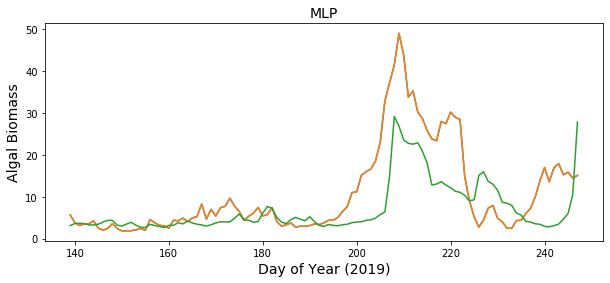

In [112]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
cnn_hybrid = predictions_hybrid [:,6]
plt.plot(doy,actual, doy, cnn_hybrid)
plt.title("MLP", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

## ConvLSTM Encoder-Decoder With Univariate Input

In [113]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

In [114]:
# train the model
def build_model_convLSTM(train, n_steps, n_length, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_features, n_outputs = train_x.shape[2], train_y.shape[1]
    # reshape into subsequences [samples, timesteps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(64, (1,3), activation='relu', input_shape=(n_steps, 1, n_length,
    n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [115]:
# make a forecast
def forecast_convLSTM(model, history, n_steps, n_length, n_input):
    # flatten data
    data = array(history)
    #data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [samples, timesteps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [116]:
# evaluate a single model
def evaluate_model_conLSTM(train, test, n_steps, n_length, n_input):
    # fit model
    model = build_model_convLSTM(train, n_steps, n_length, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)-7):
        # predict the week
        yhat_sequence = forecast_convLSTM(model, history, n_steps, n_length, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    test_x, test_y= to_supervised(test, 7, 1)  
    score, scores = evaluate_forecasts(test_x[:,:,0], predictions)
    return score, scores, predictions

In [117]:
# define the number of subsequences and the length of subsequences
n_steps, n_length = 2, 3
# define the total days to use as input
n_input = n_length * n_steps
score_convLSTM, scores_convLSTM, predictions_convLSTM = evaluate_model_conLSTM(train, test, n_steps, n_length, n_input)
# summarize scores
summarize_scores('convLSTM', score_convLSTM, scores_convLSTM)

convLSTM: [6.261] 3.2, 4.4, 5.5, 6.6, 7.4, 8.0, 8.4


In [118]:
predictions_convLSTM= predictions_convLSTM.reshape(predictions_convLSTM.shape[0], predictions_convLSTM.shape[1])

In [119]:
np.savetxt('predictions_convLSTM.csv', predictions_convLSTM, fmt='%1.6f', delimiter=',')

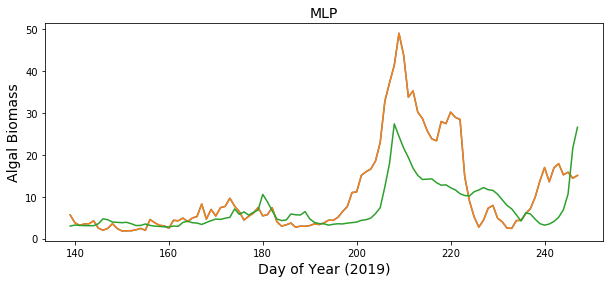

In [120]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
convLSTM = predictions_convLSTM [:,6]
plt.plot(doy,actual, doy, convLSTM)
plt.title("MLP", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

# Multi-variate

## CNN multi-channel

In [274]:
# load the new file
dataset = read_csv('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Data/Raw/ExperimentalLakes/ExperimentalLakes_Data_withColorNormalizedCumulativePloading.csv', header=0, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])


In [332]:
def data_prep_multi(dataset, lake):
    ex=dataset[dataset.lake==lake]
    ex = ex.dropna(subset=["chl"])
    ex.zmix_hf = ex.zmix_hf.fillna(ex.zmix_daily)
    ex.temp_zmix_hf = ex.temp_zmix_hf.fillna(ex.temp_zmix_daily) 
    ex = ex.interpolate()
    #ex = ex.drop(["lake",'zmix_daily','temp_zmix_daily', 'windDir_mean', 'dosat','doy','temp_Sonde','airTemp_mean','WindGust_mean','N_mg_m2_day','pH','DOconc','Zmix_hfAve','PAR_mean','windspd_mean' ], axis=1)
    #ex["cum_p"]=ex.groupby(['year'])['p_loading'].cumsum(axis=0)
    cols = ['chl']  + ['temp_zmix_hf']+['p_cumul_over_color'] 
    ex = ex[cols]    
    return ex

In [333]:
ex_R_multi= data_prep_multi(dataset, "R")
#ex_R_multi=ex_R_multi[:-2]

In [334]:
ex_T_multi= data_prep_multi(dataset, "T")

In [335]:
ex_R_multi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 932 entries, 2008-05-15 to 2019-09-05
Data columns (total 3 columns):
chl                   932 non-null float64
temp_zmix_hf          932 non-null float64
p_cumul_over_color    932 non-null float64
dtypes: float64(3)
memory usage: 29.1 KB


In [336]:
#ex_R_multi_nor=(ex_R_multi-ex_R_multi.min())/(ex_R_multi.max()-ex_R_multi.min())*100

In [337]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:816], data[816:]
	# restructure into windows of weekly data
	#train = array(split(train, len(train)/7))
	#test = array(split(test, len(test)/7))
	return train, test

In [338]:
# split a univariate dataset into train/test sets
def split_dataset_T(data):
	# split into standard weeks
	train, test = data[1:190], data[190:]
	# restructure into windows of weekly data
	#train = array(split(train, len(train)/7))
	#test = array(split(test, len(test)/7))
	return train, test

In [339]:
train_m, test_m= split_dataset(ex_R_multi.values)
train_m= train_m.reshape(train_m.shape[0],1, train_m.shape[1])
test_m= test_m.reshape(test_m.shape[0], 1, test_m.shape[1])

In [340]:
train_m_T, test_m_T= split_dataset_T(ex_T_multi.values)
train_m_T= train_m_T.reshape(train_m_T.shape[0],1, train_m_T.shape[1])
test_m_T= test_m_T.reshape(test_m_T.shape[0], 1, test_m_T.shape[1])

In [341]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [342]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [343]:
# convert history into inputs and outputs
def to_supervised_multi(train_m, n_input, n_out=7):
	# flatten data
	data = train_m.reshape((train_m.shape[0]*train_m.shape[1], train_m.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [344]:
test_x_m, test_y_m = to_supervised_multi(test_m, 7)

In [345]:
test_x_m.shape

(103, 7, 3)

In [346]:
# make a forecast
def forecast_multi(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [347]:
# train the model
def build_model_CNN_multi(train_m, n_input):
	# prepare data
	train_x, train_y = to_supervised_multi(train_m, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70,4
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(Conv1D(128, 2, activation='relu', input_shape=(n_timesteps,n_features), data_format='channels_first'))
	model.add(Conv1D(64, 2, activation='relu'))
	model.add(MaxPooling1D())
	model.add(Conv1D(16, 2, activation='relu'))
	model.add(MaxPooling1D())
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [348]:
# evaluate a single model
def evaluate_model_CNN_multi(train_m, test_m, n_input):
	# fit model
	model = build_model_CNN_multi(train_m, n_input)
	# history is a list of weekly data
	history = [x for x in train_m]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test_m)-7):
		# predict the week
		yhat_sequence = forecast_multi(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test_m[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	test_x, test_y= to_supervised_multi(test_m, 7, 1)
	score, scores = evaluate_forecasts(test_x[:, :, 0], predictions)
	return score, scores, predictions

In [349]:
# evaluate model and get scores
n_input =7
score, scores_CNN_multi, predictions_CNN_multi = evaluate_model_CNN_multi(train_m, test_m, n_input)

r_value_multiCNN= []
for i in range(7):
    r_value= stats.linregress(test_x_m[:, i, 0], predictions_CNN_multi[:, i])[2]
    r_value_multiCNN.append(r_value)

In [350]:
# summarize scores
summarize_scores('Multi-channel CNN', score, scores_CNN_multi)

Multi-channel CNN: [5.556] 3.5, 4.4, 5.0, 5.6, 6.0, 6.4, 7.0


In [351]:
predictions_CNN_multi.shape

(109, 7)

np.savetxt('predictions_CNN_multi_color.csv', predictions_CNN_multi, fmt='%1.6f', delimiter=',')

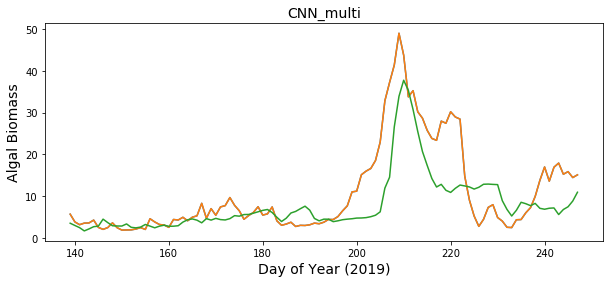

In [352]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
CNN_multi = predictions_CNN_multi [:,6]
plt.plot(doy,actual, doy, CNN_multi)
plt.title("CNN_multi", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

## CNN multi-channel

In [357]:
# evaluate model and get scores
n_input = 7
score_CNN_multi_T, scores_CNN_multi_T, prediction_CNN_multi_T= evaluate_model_CNN_multi(train_m, train_m_T, n_input)

In [358]:
# summarize scores
summarize_scores('cnn_T', score_CNN_multi_T, scores_CNN_multi_T)

cnn_T: [5.917] 3.5, 4.5, 5.2, 6.0, 6.9, 7.0, 7.3


In [359]:
train_m_T.shape

(189, 1, 3)

In [364]:
actual_T = train_T[6:-1]

In [365]:
actual_T.shape

(182, 1)

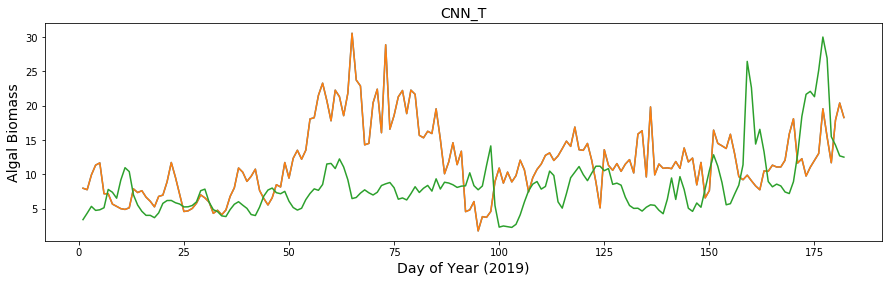

In [368]:
doy_T = range(1,183)
actual_T = train_T[6:-1]
plt.figure(figsize=(15,4))
plt.plot(doy_T,actual_T, label='Actual')
CNN_multi_T = prediction_CNN_multi_T [:,6]
plt.plot(doy_T,actual_T, doy_T, CNN_multi_T)
plt.title("CNN_T", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

## Multi-headed CCN

In [300]:
from keras.utils.vis_utils import plot_model
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.models import Model

In [301]:
# plot training history
def plot_history(history):
    # plot loss
    pyplot.subplot(2, 1, 1)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.title('loss', y=0, loc='center')
    pyplot.legend()
    # plot rmse
    pyplot.subplot(2, 1, 2)
    pyplot.plot(history.history['rmse'], label='train')
    pyplot.plot(history.history['val_rmse'], label='test')
    pyplot.title('rmse', y=0, loc='center')
    pyplot.legend()
    pyplot.show()

In [302]:
# train the model
def build_model_multiheaded(train_m, n_input):
    # prepare data
    train_x, train_y = to_supervised_multi(train_m, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 70,4
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # create a channel for each variable
    in_layers, out_layers = list(), list()
    for _ in range(n_features):
        inputs = Input(shape=(n_timesteps,1))
        conv1 = Conv1D(32, 2, activation='relu')(inputs)
        conv2 = Conv1D(32, 2, activation='relu')(conv1)
        pool1 = MaxPooling1D()(conv2)
        flat = Flatten()(pool1)
    # store layers
        in_layers.append(inputs)
        out_layers.append(flat)
    # merge heads
    merged = concatenate(out_layers)
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    dense2 = Dense(300, activation='relu')(dense1)
    outputs = Dense(n_outputs)(dense2)
    model = Model(inputs=in_layers, outputs=outputs)
    # compile model
    model.compile(loss='mse', optimizer='adam')
    # plot the model
    #plot_model(model, show_shapes=True, to_file='multiheaded_cnn.png')
    # fit network
    input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]
    model.fit(input_data, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [303]:
# make a forecast
def forecast_multi_headed(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into n input arrays
    input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [304]:
# evaluate a single model
def evaluate_model_multi_headed(train_m, test_m, n_input):
    # fit model
    model = build_model_multiheaded(train_m, n_input)
    # history is a list of weekly data
    history = [x for x in train_m]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test_m)-7):
        # predict the week
        yhat_sequence = forecast_multi_headed(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test_m[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    test_x, test_y= to_supervised_multi(test_m, 7, 1)
    score, scores = evaluate_forecasts(test_x[:, :, 0], predictions)
    return score, scores, predictions

In [305]:
n_input = 7
score_multi_headed, scores_multi_headed, predictions_multi_headed = evaluate_model_multi_headed(train_m, test_m, n_input)
# summarize scores
summarize_scores('multi headed_CNN', score_multi_headed, scores_multi_headed)

multi headed_CNN: [7.532] 5.3, 6.6, 7.6, 8.4, 8.3, 8.0, 8.0


In [306]:
np.savetxt('predictions_multi_headed.csv', predictions_multi_headed,fmt='%1.6f', delimiter=',')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/nn2tf/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-306-01acbed22142>", line 1, in <module>
    np.savetxt('predictions_multi_headed.csv', predictions_multi_headed,fmt='%1.6f', delimiter=',')
  File "/Users/nn2tf/anaconda3/lib/python3.7/site-packages/numpy/lib/npyio.py", line 1359, in savetxt
    open(fname, 'wt').close()
FileNotFoundError: [Errno 2] No such file or directory: 'predictions_multi_headed.csv'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/nn2tf/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2039, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred

FileNotFoundError: [Errno 2] No such file or directory: 'predictions_multi_headed.csv'

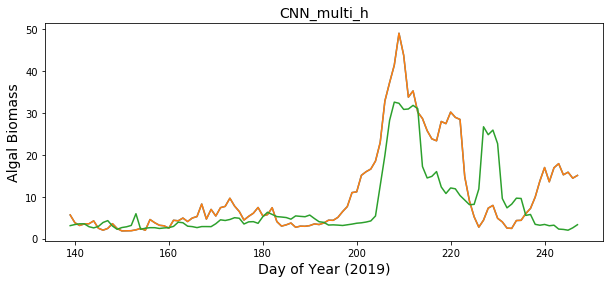

In [307]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
CNN_multi_h = predictions_multi_headed [:,6]
plt.plot(doy,actual, doy, CNN_multi_h)
plt.title("CNN_multi_h", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

## Encoder-Decoder LSTM With Multivariate Input

In [247]:
# train the model
def build_model_LSTM_multi(train_m, n_input):
    # prepare data
    train_x, train_y = to_supervised_multi(train_m, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [248]:
# evaluate a single model
def evaluate_model_LSTM_multi(train_m, test_m, n_input):
	# fit model
	model = build_model_LSTM_multi(train_m, n_input)
	# history is a list of weekly data
	history = [x for x in train_m]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test_m)-7):
		# predict the week
		yhat_sequence = forecast_multi(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test_m[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	test_x, test_y= to_supervised_multi(test_m, 7, 1)
	score, scores = evaluate_forecasts(test_x[:, :, 0], predictions)
	return score, scores, predictions

In [249]:
# evaluate model and get scores
n_input = 7
score, scores_LSTM_multi, predictions_LSTM_multi = evaluate_model_LSTM_multi(train_m, test_m, n_input)

In [250]:
# summarize scores
summarize_scores('LSTM_multi', score, scores_LSTM_multi)


LSTM_multi: [6.018] 3.4, 4.4, 5.3, 6.2, 6.8, 7.2, 7.6


In [251]:
predictions_LSTM_multi= predictions_LSTM_multi.reshape(predictions_LSTM_multi.shape[0], predictions_LSTM_multi.shape[1])

In [252]:
np.savetxt('predictions_LSTM_multi.csv', predictions_LSTM_multi, fmt='%1.6f', delimiter=',')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/nn2tf/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-252-8bd17f8f7d43>", line 1, in <module>
    np.savetxt('predictions_LSTM_multi.csv', predictions_LSTM_multi, fmt='%1.6f', delimiter=',')
  File "/Users/nn2tf/anaconda3/lib/python3.7/site-packages/numpy/lib/npyio.py", line 1359, in savetxt
    open(fname, 'wt').close()
FileNotFoundError: [Errno 2] No such file or directory: 'predictions_LSTM_multi.csv'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/nn2tf/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2039, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Tr

FileNotFoundError: [Errno 2] No such file or directory: 'predictions_LSTM_multi.csv'

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(doy,actual, label='Actual')
LSTM_multi = predictions_LSTM_multi [:,6]
plt.plot(doy,actual, doy, LSTM_multi)
plt.title("LSTM_multi", fontsize=14)
plt.xlabel('Day of Year (2019)',fontsize=14)
plt.ylabel('Algal Biomass',fontsize=14)
plt.show()

# Summarize results

### Plot 1- Comparing the performance

In [ ]:
days = ['1', '2', '3', '4', '5', '6', '7']
mech = [6.371254058, 9.964882012,10.3674918,10.52675684,10.58225691,10.82599927,11.16455892]
# plot scores
pyplot.figure(figsize=(12,9))
pyplot.plot(days, scores_Naive,marker='o', label="Naive (Persistence)", color='Black', linewidth=2)
pyplot.plot(days, mech,marker='*', label="Mechanistic Model")
pyplot.plot(days, scores_CNN_multi,marker='d', label="Deep Learning Model (CNN)")


# show plot
pyplot.legend(fontsize=14, loc=4)
pyplot.grid()
pyplot.xlabel("Forecast Herizon (days)",fontsize=16)
pyplot.ylabel("RMSE",fontsize=16)
pyplot.savefig('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/comparison paper/Figures/performance.jpeg')
pyplot.show()

In [ ]:
days = ['1', '2', '3', '4', '5', '6', '7']
# plot scores
pyplot.figure(figsize=(12,9))
pyplot.plot(days, scores_Naive,marker='o', label="Naive (Persistence)", color='Black', linewidth=2.5)
pyplot.plot(days, scores_CNN,marker='x', label="Convoloutional Neural Net (CNN)")
pyplot.plot(days, scores_LSTM,marker='x', label="Long Short-term Memory (LSTM)" )
pyplot.plot(days, scores_hybrid,marker='x', label='Hybrid (CNN-LSTM)')
pyplot.plot(days, scores_convLSTM,marker='o', label='Hybrid (ConvLSTM)')
pyplot.plot(days, scores_LSTM_EnDe,marker='o', label='Encoder-Decoder LSTM')
pyplot.plot(days, scores_MLP,marker='o', label="Multi-layer Perceptron (MLP)")
pyplot.plot(days, scores_CNN_multi,marker='d', label="Multi-variate CNN")
pyplot.plot(days, scores_multi_headed,marker='o', label='multi-headed CNN (Multi-variate)')
pyplot.plot(days, scores_LSTM_multi, marker='d',label='Multi-variate LSTM')
#pyplot.plot(days, mech_Log_const.Normalized_RMSE, marker='o',label="Log. - const. K")

# show plot
pyplot.legend(fontsize=14, loc=2)
pyplot.grid()
pyplot.xlabel("Forecast Length (days)",fontsize=16)
pyplot.ylabel("Normalized RMSE",fontsize=16)
pyplot.savefig('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Results/Lake R/MLperformance.jpeg')
pyplot.show()



In [ ]:
days = ['1', '2', '3', '4', '5', '6', '7']
# plot scores
pyplot.figure(figsize=(12,9))
pyplot.plot(days, scores_Naive,marker='o', label="Naive (Persistence)", color='Black', linewidth=2.5)
#pyplot.plot(days, scores_CNN,marker='o', label="Convoloutional Neural Net (CNN)")
#pyplot.plot(days, scores_LSTM,marker='o', label="Long Short-term Memory (LSTM)" )
#pyplot.plot(days, scores_hybrid,marker='o', label='Hybrid (CNN-LSTM)')
#pyplot.plot(days, scores_convLSTM,marker='o', label='Hybrid (ConvLSTM)')
#pyplot.plot(days, scores_LSTM_EnDe,marker='o', label='Encoder-Decoder LSTM')
#pyplot.plot(days, scores_MLP,marker='o', label="Multi-layer Perceptron (MLP)")
pyplot.plot(days, scores_CNN_multi,marker='d', label="Multi-variate CNN", color='r')
#pyplot.plot(days, scores_multi_headed,marker='o', label='multi-headed CNN (Multi-variate)')
#pyplot.plot(days, scores_LSTM_multi, marker='o',label='Multi-variate LSTM')
pyplot.plot(days, mech_Log_const.Normalized_RMSE, marker='o',label="Mechanistic (Log. - const. K)", color='teal')
pyplot.plot(days, stat_ARIMA.Normalized_RMSE, marker='o',label="ARIMA", color='purple')
# show plot
pyplot.legend(fontsize=14, loc=2)
pyplot.grid()
pyplot.xlabel("Forecast Length (days)",fontsize=16)
pyplot.ylabel("Normalized RMSE",fontsize=16)
pyplot.savefig('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Results/Lake R/Allperformance.jpeg')
pyplot.show()



In [ ]:
days = range(133,240)
pyplot.figure(figsize=(15,5))
pyplot.plot(days,test[:-7], label='Actual')
pyplot.plot(days, ex_R[810:-14], label='Naive', color='black')
#pyplot.plot(days,prediction_CNN[:,6],label="CNN")
#pyplot.plot(days,predictions_LSTM[:,6],label="Long Short-term Memory (LSTM)")
#pyplot.plot(days, predictions_convLSTM[:,6],label="convLSTM")
#pyplot.plot(days, predictions_hybrid[:,6],label="cnn_hybrid")
#pyplot.plot(days, predictions_LSTM_EnDe[:,6],label="LSTM_EnDe")
#pyplot.plot(days, predictions_MLP[:,6],label="MLP")
pyplot.plot(days, predictions_CNN_multi[:,6],label="Multi-variate CNN")
#pyplot.plot(days, predictions_LSTM_multi[:,6],label="Multi-variate LSTM")
pyplot.legend(fontsize=12, loc=2)
pyplot.title("7-day forecast, lake Peter, 2019", fontsize=14)
pyplot.xlabel('Day of Year (2019)',fontsize=14)
pyplot.ylabel('Algal Biomass',fontsize=14)
pyplot.savefig('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Results/Lake R/ML-7-daysForecast.jpeg')
pyplot.show()

In [ ]:
days

In [ ]:
days = range(133,240)
pyplot.figure(figsize=(15,5))
pyplot.plot(days,test[:-7], label='Actual')
pyplot.plot(days, ex_R[810:-14], label='Naive', color='black')
#pyplot.plot(days,prediction_CNN[:,6],label="CNN")
#pyplot.plot(days,predictions_LSTM[:,6],label="Long Short-term Memory (LSTM)")
#pyplot.plot(days, predictions_convLSTM[:,6],label="convLSTM")
#pyplot.plot(days, predictions_hybrid[:,6],label="cnn_hybrid")
#pyplot.plot(days, predictions_LSTM_EnDe[:,6],label="LSTM_EnDe")
#pyplot.plot(days, predictions_MLP[:,6],label="MLP")
pyplot.plot(days, predictions_CNN_multi[:,6],label="Multi-variate CNN")
#pyplot.plot(days, predictions_LSTM_multi[:,6],label="Multi-variate LSTM")
pyplot.plot(forecast_arima_7[2:-10].doy,forecast_arima_7[2:-10].Forecast, label='ARIMA')
#pyplot.plot(forecast_mech_7[2:-10].doy,forecast_mech_7[2:-10].Forecast, label='Mechanistic, logistic Constant K')
pyplot.legend(fontsize=12, loc=2)
pyplot.title("7-day forecast, lake Peter, 2019", fontsize=14)
pyplot.xlabel('Day of Year (2019)',fontsize=14)
pyplot.ylabel('Algal Biomass',fontsize=14)
pyplot.savefig('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Results/Lake R/All model-7-daysForecast.jpeg')
pyplot.show()

In [ ]:
#5-day forecasting
days = range(133,240)
pyplot.figure(figsize=(15,5))
pyplot.plot(days,test[:-7], label='Actual')
pyplot.plot(days, predictions_CNN_multi[:,0],label="One-day forecast")
pyplot.plot(days, predictions_CNN_multi[:,2],label="Three-day forecast")
pyplot.plot(days, predictions_CNN_multi[:,6],label="Seven-day forecast")
pyplot.legend(loc=2, fontsize=12)
pyplot.title("Multi-channel CNN, lake Peter, 2019")
pyplot.xlabel('Days of Year (2019)')
pyplot.ylabel('Algal Biomass')
pyplot.savefig('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Results/Lake R/1-3-7.jpeg')
pyplot.show()

In [ ]:
#5-day forecasting
days = range(133,240)
pyplot.figure(figsize=(15,5))
pyplot.plot(days,test[:-7], label='Actual')
pyplot.plot(days, predictions_hybrid[:,0],label="One-day forecast")
pyplot.plot(days, predictions_hybrid[:,2],label="Three-day forecast")
pyplot.plot(days, predictions_hybrid[:,6],label="Seven-day forecast")
pyplot.legend(loc=2, fontsize=12)
pyplot.title("Multi-channel CNN, lake Peter, 2019", fontsize=14)
pyplot.xlabel('Days of Year (2019)', fontsize=14)
pyplot.ylabel('Algal Biomass', fontsize=14)
pyplot.show()

In [ ]:
# load the new file
Raw = read_csv('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Data/Raw/ExperimentalLakes/experimentalLakes_combinedData_daily_allDates_v1.csv', header=0, infer_datetime_format=True)
Raw_R = Raw[Raw.Lake=='R']
Raw_R = Raw_R.dropna(subset=["Chl"])

In [ ]:
Raw_R.info()

In [ ]:
#Raw_R=Raw_R.set_index('Date')

In [ ]:
Raw_R.Date = pd.to_datetime(Raw_R.Date)
Raw_train=Raw_R[Raw_R['Year']<2019]
Raw_test=Raw_R[Raw_R['Year']==2019]

In [ ]:
 #!/usr/bin/python
from matplotlib import pyplot as plt
from matplotlib import dates
from datetime import datetime
import sys
days = dates.DayLocator()
Months = dates.MonthLocator()
years = dates.YearLocator()
dfmt = dates.DateFormatter('%Y') 
datemin = datetime(2008, 1,1)
datemax = datetime(2019, 12,31)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(dfmt)
ax.xaxis.set_minor_locator(Months)
ax.set_xlim(datemin, datemax)
ax.set_ylabel('Biomass Abundance')
ax.grid(True)
ax.plot(Raw_train.Date, Raw_train.Chl, label='Train')
fig.set_size_inches(15, 7)

In [ ]:













#plt.savefig('temperatures.pdf', format='pdf')

In [ ]:
plt.figure(figsize=(15,5))
Raw_train.plot( y=['Chl'], rot=45)
Raw_test.plot(y=['Chl'], rot=45)
plt.xlabel('Date')
plt.ylabel('Algal Biomass')
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#plt.savefig('Scatterplot_dailychlor.png')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
ax = plt.axes()
plt.rcParams["figure.figsize"] = (15,5)
ax.plot(Raw_train.Date, Raw_train.Chl, label='Train')
ax.plot(Raw_test.Date, Raw_test.Chl, color='red', label='Test')
pyplot.legend(loc=2, fontsize=12)
pyplot.title("Train-Test Split", fontsize=14)
pyplot.xlabel('Date', fontsize=14)
pyplot.ylabel('Algal Biomass', fontsize=14)
plt.show()

In [ ]:
pyplot.figure(figsize=(15,5))

pyplot.plot(Raw_train.Chl, label='Train set')
pyplot.plot(Raw_test.Chl, color='red', label='Test set')
#pyplot.plot(X,Y, label='Actual')
pyplot.legend(loc=2, fontsize=12)
pyplot.title("Train-Test Split", fontsize=14)
pyplot.xlabel('Date', fontsize=14)
pyplot.ylabel('Algal Biomass', fontsize=14)
pyplot.savefig('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Results/Lake R/train-test.jpeg')
pyplot.show()

In [ ]:
# load the new file
statistical = read_csv('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Results/StatisticalModels_withNaive_RMSE_normalized.csv', header=0)
Mechanistic = read_csv('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Results/MechanisticModels_withNaive_RMSE_normalized.csv', header=0)
statistical = read_csv('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Results/StatisticalModels_withNaive_RMSE_normalized.csv', header=0)

In [ ]:
stat_R=statistical[statistical.Lake=='R']
mech_R=Mechanistic[Mechanistic.Lake=='R']

In [ ]:
mech_R.info()

In [ ]:
set(stat_R.Model)

In [ ]:
stat_ARIMA=stat_R[stat_R.Model=='ARIMA']
stat_ARIMA_1=stat_R[stat_R.Model=='ARIMA - 1st diff.']
stat_Naive=stat_R[stat_R.Model=='Naive']
stat_SETAR=stat_R[stat_R.Model=='SETAR']
stat_SETAR_1=stat_R[stat_R.Model=='SETAR - 1st Diff.']

In [ ]:
# plot scores
pyplot.figure(figsize=(12,9))
pyplot.plot(stat_Naive.horizon, stat_Naive.Normalized_RMSE, marker='o',label="Naive", color='Black', linewidth=2.5)
pyplot.plot(stat_ARIMA.horizon, stat_ARIMA.Normalized_RMSE, marker='o',label="ARIMA")
pyplot.plot(stat_ARIMA_1.horizon, stat_ARIMA_1.Normalized_RMSE, marker='o',label="ARIMA - 1st diff.")
pyplot.plot(stat_SETAR.horizon, stat_SETAR.Normalized_RMSE, marker='o',label="stat_SETAR")
pyplot.plot(stat_SETAR_1.horizon, stat_SETAR_1.Normalized_RMSE, marker='o',label="SETAR - 1st Diff.")
# show plot
pyplot.legend(loc=2, fontsize=12)
pyplot.grid()
#pyplot.title()
pyplot.xlabel("Forecast Length (days)", fontsize=16)
pyplot.ylabel("Normalized RMSE", fontsize=16)
pyplot.savefig('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Results/Lake R/statperformance.jpeg')
pyplot.show()

In [ ]:
mech_Exp_load= mech_R[mech_R.Model=='Exp. - load.']
mech_Exp_load_ir= mech_R[mech_R.Model=='Exp. - load. & irr.']
mech_Naive = mech_R[mech_R.Model=='Naive']
mech_Log_const = mech_R[mech_R.Model=='Log. - const. K']
mech_Log_load = mech_R[mech_R.Model=='Log. - load. K']

In [ ]:
# plot scores
pyplot.figure(figsize=(12,9))
pyplot.plot(stat_Naive.horizon, stat_Naive.Normalized_RMSE, marker='o', label="Naive", color='Black', linewidth=2.5)
pyplot.plot(mech_Exp_load.horizon, mech_Exp_load.Normalized_RMSE, marker='o',label="Exp. - load.")
pyplot.plot(mech_Exp_load_ir.horizon, mech_Exp_load_ir.Normalized_RMSE, marker='o', label="Exp. - load. & irr.")
pyplot.plot(mech_Log_const.horizon, mech_Log_const.Normalized_RMSE, marker='o',label="Log. - const. K")
pyplot.plot(mech_Log_load.horizon, mech_Log_load.Normalized_RMSE,marker='o', label="Log. - load. K")
# show plot
pyplot.legend(loc=2, fontsize=12)
pyplot.grid()
#pyplot.title()
pyplot.xlabel("Forecast Length (days)", fontsize=16)
pyplot.ylabel("Normalized RMSE", fontsize=16)
pyplot.savefig('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Results/Lake R/mechperformance.jpeg')
pyplot.show()

In [ ]:
forecast_arima = read_csv('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Results/Forecasts_ARIMA_Peter2019_formatted_normalized.csv', header=0)
forecast_mech = read_csv('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Results/Forecasts_Mechanistic_logisticConstantK_Peter2019_formatted_normalized.csv', header=0)

In [ ]:
forecast_arima.info()

In [ ]:
forecast_mech_7=forecast_mech[forecast_mech.horizon==7]

In [ ]:
forecast_arima_7=forecast_arima[forecast_arima.horizon==7]
forecast_arima_3=forecast_arima[forecast_arima.horizon==3]
forecast_arima_1=forecast_arima[forecast_arima.horizon==1]

In [ ]:
days = range(133,240)
pyplot.figure(figsize=(15,5))
pyplot.plot(forecast_arima_7.doy,forecast_arima_7.Forecast_Naive, label='Naive', color= 'black')
pyplot.plot(forecast_arima_7.doy,forecast_arima_7.Chl, label='Actual')
pyplot.plot(forecast_arima_7.doy,forecast_arima_7.Forecast, label='ARIMA')
pyplot.legend(fontsize=12, loc=2)
pyplot.title("7-day forecast, lake Peter, 2019", fontsize=14)
pyplot.xlabel('Day of Year (2019)',fontsize=14)
pyplot.ylabel('Algal Biomass',fontsize=14)
pyplot.savefig('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Results/Lake R/stat-7-daysForecast.jpeg')
pyplot.show()

In [ ]:
days = range(133,240)
pyplot.figure(figsize=(15,5))
pyplot.plot(forecast_mech_7.doy,forecast_mech_7.Forecast_Naive, label='Naive', color= 'black')
pyplot.plot(forecast_mech_7.doy,forecast_mech_7.Chl, label='Actual')
pyplot.plot(forecast_mech_7.doy,forecast_mech_7.Forecast, label='Mechanistic, logistic Constant K')
pyplot.legend(fontsize=12, loc=2)
pyplot.title("7-day forecast, lake Peter, 2019", fontsize=14)
pyplot.xlabel('Day of Year (2019)',fontsize=14)
pyplot.ylabel('Algal Biomass',fontsize=14)
pyplot.savefig('/Volumes/GoogleDrive/My Drive/UVa/Spring2019/Presidential Fellowship/BloomForecasting/Results/Lake R/-mech-7-daysForecast.jpeg')
pyplot.show()

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(forecast_arima_1.Chl[2:-10],forecast_arima_1[2:-10].Forecast)
r_squared = r_value * r_value
print(slope, intercept, r_value, p_value, std_err, r_squared)

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(forecast_arima_3.Chl[5:-10],forecast_arima_3[5:-10].Forecast)
r_squared = r_value * r_value
print(slope, intercept, r_value, p_value, std_err, r_squared)

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(forecast_arima_7.Chl[9:-10],forecast_arima_7[9:-10].Forecast)
r_squared = r_value * r_value
print(slope, intercept, r_value, p_value, std_err, r_squared)

In [ ]:
import seaborn as sns
Naive1 = sns.regplot(x=test_x[:, 0, 0], y=prediction_Naive[:, 0])
pyplot.xlabel('CHLa Observed',fontsize=14)
pyplot.ylabel('CHLa Predicted ',fontsize=14)
pyplot.show()
Naive3 = sns.regplot(x=test_x[:, 2, 0], y=prediction_Naive[:, 2])
pyplot.xlabel('CHLa Observed',fontsize=14)
pyplot.ylabel('CHLa Predicted ',fontsize=14)
pyplot.show()
Naive7 = sns.regplot(x=test_x[:, 6, 0], y=prediction_Naive[:, 6])
pyplot.xlabel('CHLa Observed',fontsize=14)
pyplot.ylabel('CHLa Predicted ',fontsize=14)
pyplot.show()
CNN1 = sns.regplot(x=test_x[:, 0, 0], y=predictions_CNN_multi[:, 0])
pyplot.xlabel('CHLa Observed',fontsize=14)
pyplot.ylabel('CHLa Predicted ',fontsize=14)
pyplot.show()
CNN3 = sns.regplot(x=test_x[:, 2, 0], y=predictions_CNN_multi[:, 2])
pyplot.xlabel('CHLa Observed',fontsize=14)
pyplot.ylabel('CHLa Predicted ',fontsize=14)
pyplot.show()
CNN7 = sns.regplot(x=test_x[:, 6, 0], y=predictions_CNN_multi[:, 6])
pyplot.xlabel('CHLa Observed',fontsize=14)
pyplot.ylabel('CHLa Predicted ',fontsize=14)
pyplot.show()
ARIMA1 = sns.regplot(x=forecast_arima_1.Chl, y=forecast_arima_1.Forecast)
pyplot.xlabel('CHLa Observed',fontsize=14)
pyplot.ylabel('CHLa Predicted ',fontsize=14)
pyplot.show()
ARIMA3 = sns.regplot(x=forecast_arima_3.Chl, y=forecast_arima_3.Forecast)
pyplot.xlabel('CHLa Observed',fontsize=14)
pyplot.ylabel('CHLa Predicted ',fontsize=14)
pyplot.show()
ARIMA7 = sns.regplot(x=forecast_arima_7.Chl, y=forecast_arima_7.Forecast)
pyplot.xlabel('CHLa Observed',fontsize=14)
pyplot.ylabel('CHLa Predicted ',fontsize=14)
pyplot.show()



### Residual Calculation

In [ ]:
Res_Naive7= test_y[0]- prediction_Naive[:, 6]
Res_ARIMA7= forecast_arima_7[9:-10].Chl-forecast_arima_7[9:-10].Forecast
Res_CNN7= test_y[0] - predictions_CNN_multi[:, 6]

In [ ]:
Res_Naive7

In [ ]:
1-np.std(prediction_Naive[:, 6])/np.std(test_x[:, 0, 0])

In [ ]:
1-np.std(forecast_arima_7.Chl[9:-10])/np.std(test_x[:, 0, 0])

In [ ]:
1-np.std(predictions_CNN_multi[:, 6])/np.std(test_x[:, 0, 0])

### Residual Distribution

In [ ]:
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# best fit of data
(mu, sigma) = norm.fit(Res_Naive7)

# the histogram of the data
_, bins, _ = plt.hist(Res_Naive7, 20, density=1)

# add a 'best fit' line
y = norm.pdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

#plot
plt.xlabel('Naive Forecast Residuals')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)

plt.show()

In [ ]:
# best fit of data
(mu, sigma) = norm.fit(Res_ARIMA7)

# the histogram of the data
_, bins, _ = plt.hist(Res_ARIMA7, 20, density=1, alpha=0.8)

# add a 'best fit' line
y = norm.pdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

#plot
plt.xlabel('ARIMA Forecast Residuals')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)

plt.show()

In [ ]:
# best fit of data
(mu, sigma) = norm.fit(Res_CNN7)

# the histogram of the data
_, bins, _ = plt.hist(Res_CNN7, 20, density=1, alpha=0.8)

# add a 'best fit' line
y = norm.pdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)

#plot
plt.xlabel('CNN Forecast Residuals')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)

plt.show()

### Plot 1- Performance comparison